# Attendance

[The link to SEAts](https://gold.seats.cloud/angular/#/lectures)

---

## 11.4 The Transformer architecture


In [1]:
import os
import sys
import shutil
import random
import pathlib

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo

### The Transformer architecture

<!-- <img style="float:right" src="images/transformer/the-annotated-transformer_14_0.transformer-full.png"> -->
<img style="float:right" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/the-annotated-transformer_14_0.transformer-full.png?raw=true">


<small style="position:absolute;bottom:0;right:0">[Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

The **Transformer** architecture was developed for NLP, specifically for translation.

The dual architecture pattern (*sequence to sequence*) reflects this:
- the left-hand side (**"reading"**) transforms an **input** sentence into abstract representations;
- the right hand side (**"generation"**) transforms the **output** sentence into abstract representations;
- the output probabilities ("what is the next token?") are produced on the basis of both branches!

### Transormers: before

<!-- <img style="float:right;height:650px" src="images/transformer/beyer.takeover.1.png"> -->
<img style="float:right;height:650px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.takeover.1.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit)</small>

### Transormers: after

<!-- <img style="float:right;height:650px" src="images/transformer/beyer.takeover.2.png"> -->
<img style="float:right;height:650px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.takeover.2.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit)</small>

### Three variants/applications

<!-- <img style="float:right;height:650px" src="images/transformer/beyer.gpt-bert-t5.png"> -->
<img style="float:right;height:650px"  src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.gpt-bert-t5.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit)</small>

---

### 11.4.1 Understanding self-attention

#### Generalized self-attention: the query-key-value model

<!-- <img style="" src="images/transformer/chollet.key-query-value.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/chollet.key-query-value.png?raw=true">


<small>DLWP, p.341</small>

<!-- ![Stanford CS224n soft look-up](images/cs224n/02.soft-lookup.png) -->
<img style="height:750px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/cs224n/02.soft-lookup.png?raw=true">

[Stanford CS224n, lecture 8](https://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture08-transformers.pdf#page=8&zoom=auto,-74,536) ([YouTube](https://www.youtube.com/watch?v=LWMzyfvuehA))

<!-- <imgsrc="images/transformer/chollet.attention.2.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/chollet.attention.2.png?raw=true">


<small>DLWP, p.338</small>

### The operations of attention

1. First, we **transform our input sequence** $X$ (`timesteps_x` x `embedding_dim_x`) by integrating information from a context sequence $Y$ (`timesteps_y` x `embedding_dim_y`), each token is a vector embedding) into **Keys**, **Queries**, and **Values**, using three different matrices (here denoted $W$):

$$
Q = XW_Q, \qquad K = YW_K, \qquad V = YW_V
$$

With:
- $t$ denotes time steps, $d$ embedding dimensions, $t_X$ and $t_Y$ are the lengths of the respective sequences
, and $d_k$ is the space dimension of the attention operation, `attn_dim`:
- $X$: $t_X \times d_x$
- $Y$: $t_Y \times d_y$
- $W_Q$: $d_x \times d_k$, therefore $Q$: $ t_X \times d_k $
- $W_K$: $d_y \times d_k$, therefore  $K$: $ t_Y \times d_k$
- $W_V$: $d_y \times  d_{out}$, therefore $V$: $  t_Y \times d_{out}$

**Note**

Very often $X = Y$, we aggregate input $X$ with itself. That means that $d_X = d_Y$. Also, often $d_{out} = d_{embed}$: our output sequence has the same number of time steps as our input, and the same embedding dimension.

2. Then, we perform the **attention** proper:

$$
\begin{align*}
\mathrm{Attention}(Q, K, V) &= softmax(\frac{QK^T}{\sqrt{d_k}})V\\
\\
& = softmax(\frac{QK^T}{scaling})V \\
\\
&= \bbox[5px,border:2px solid red]{“softmax(\mathrm{Queries} \cdot \mathrm{Keys)} \cdot \mathrm{Values}”}\\
\\
&= \underbrace{ \underbrace{ softmax( \overbrace{ \mathrm{Queries} \cdot \mathrm{Keys} }^{  \text{how much each source token is compatible with all context tokens} } )  }_{ \text{turn compatibilities into a normalised mask} } \cdot \mathrm{Values}  }_{ \text{turn each token into a weighted average of all context tokens} }\\
\end{align*}
$$

$Q$: queries ($t_X \times d_k$)  
$K$: keys ($t_Y \times d_k$)  
$V$: values ($t_Y \times d_{out}$)  
$\sqrt{d_k}$: scaling factor, $d_k$: dimension of $Q$ (same as $K$), to prevent small gradients.

#### Attention: the maths

$$
\begin{aligned}
QK^T & =
\begin{pmatrix}
- & q_1 & -\\
- & \vdots & -\\
- & q_{t_X} & - \\
\end{pmatrix}_{t_X \times d_k} \begin{pmatrix}
| & | & |\\
k_1 & \cdots & k_{t_Y}\\
| & | & |\\
\end{pmatrix}_{d_k \times t_Y} =
\begin{pmatrix}
q_1 k_1 & \cdots & q_1 k_{t_Y}\\
\vdots & \cdots & \vdots \\
q_{t_X} k_1 & \cdots & q_{t_X} k_{t_Y}\\
\end{pmatrix}_{t_X \times t_Y} \\
\\
& =
\begin{pmatrix}
w_{11} & \cdots & w_{1 t_Y}\\
\vdots & \cdots & \vdots \\
w_{t_X1} & \cdots & w_{t_X t_Y}\\
\end{pmatrix}_{t_X \times t_Y} \\
\\
& \rightarrow \begin{pmatrix}
\frac{w_{11}}{\sqrt{d_k}} & \cdots & \frac{w_{1 t_Y}}{\sqrt{d_k}}\\
\vdots & \cdots & \vdots \\
\frac{w_{t_X 1}}{\sqrt{d_k}} & \cdots & \frac{w_{t_X t_Y}}{\sqrt{d_k}}\\
\end{pmatrix}_{t_X \times t_Y}
\end{aligned}
$$

Again, more often than not $t_X = t_Y$, therefore the attention matrix is square.

The number $w_{ij}$ describes who similar/close $q_i$ (the query for token i in the source) is to $k_j$ (the key for token j in the context).

Then we normalize along the rows, so that the numbers in each can be interpreted as weighting factors:

$$
\begin{pmatrix}
softmax( w_{11} & \cdots & w_{1 t_Y})\\
\vdots & \cdots & \vdots \\
softmax(w_{t_X 1} & \cdots & w_{t_X t_Y})\\
\end{pmatrix} =
\begin{pmatrix}
\frac{e^{ w_{11} } }{ \sum_i e^{w_{1i}} } & \cdots & \frac{e^{ w_{1 t_Y} } }{ \sum_i e^{w_{1i}} }\\
\vdots & \cdots & \vdots \\
\frac{e^{ w_{t_X 1} } }{ \sum_i e^{w_{t_X i} } } & \cdots & \frac{e^{ w_{d_k t_Y} } }{ \sum_i e^{w_{t_X i}} }\\
\end{pmatrix}  =
\begin{pmatrix}
w'_{11} & \cdots & w'_{1 t_Y}\\
\vdots & \cdots & \vdots \\
w'_{t_X 1} & \cdots & w'_{t_X t_Y}\\
\end{pmatrix}_{t_X \times t_Y} = A
$$


Mix the values using the normalized weights:

$$
\begin{aligned}
softmax(QK^T)V = A V & =
\begin{pmatrix}
- & w'_1 & -\\
- & \vdots & - \\
- & w'_{t_X} &  -\\
\end{pmatrix}_{t_X \times t_Y}
\begin{pmatrix}
- & v_1 & -\\
- & \cdots & -\\
- & v_{t_Y} & - \\
\end{pmatrix}_{t_Y \times d_{out}}\\
& =
\begin{pmatrix}
- & x'_1 & -\\
- & \vdots & - \\
- & x'_{t_X} &  -\\
\end{pmatrix}_{t_X \times d_{out}} = X'
\end{aligned}
$$

$X'$ is our output matrix (`timesteps_x`, `embedding_dim_x_prime`) composed of all $x'_i$ vectors representing each updated, 'enriched' tokens (having incorporated information from $Y$). More often than not, $d_{out} = d_X$, the embedding dimension of the output is the same as the one of the input.


Each new vector $v_i$ merges the all the dimensions of the previous vectors $v$ according to the weighting given by $w$:

$$
\begin{aligned}
& \begin{pmatrix}
- & w'_1 & -\\
- & \cdots & - \\
- & w'_{t_X} &  -\\
\end{pmatrix}_{t_X \times t_Y}
\begin{pmatrix}
- & v_1 & -\\
- & \vdots & -\\
- & v_{t_Y} & - \\
\end{pmatrix}_{t_Y \times d_{out}} = \\
\\
= & \begin{pmatrix}
- & \color{red}{w'_1} & -\\
\vdots & \cdots & \vdots \\
- & w'_{t_X} &  -\\
\end{pmatrix}_{t_X \times t_Y}
\begin{pmatrix}
\overbrace{\color{blue}{v_{11}}}^{ \color{blue}{v'_1}\text{: first dim across all } t_Y } & \cdots & v_{1 t_{out}} \\
\vdots & \cdots & \vdots \\
\color{blue}{v_{t_Y 1}} & \cdots & v_{t_Y  t_{out}} \\
\end{pmatrix}_{t_Y \times d_{out}} \\
\\
= & \begin{pmatrix}
\color{red}{w'_{11}} \color{blue}{v'_1} & \cdots & x'_1 & -\\
- & \cdots & \vdots & - \\
- & \cdots & x'_{t_X} &  -\\
\end{pmatrix}_{t_X \times d_{out}}
\end{aligned}
$$

$\color{red}{w_1}$, in this example, will control how much each of the $v$s will contribute to new, updated vector $x'_1$ (our updated vector representation for token 1).

Each $o_i$ will have aggregated information from all $v$ (including itself) using the normalised weighting $w_i$. 


### Notes

- We saw the concept of a **gate** being like a smooth 1/0 switch. Here the *softmax* is used in the same way, for a whole array of values (letting more or less information flow through from different tokens as you mix/average their values).
- The dot product is a fairly straightforward **similarity measure** between two vectors.

### Causal Masking: Preventing look-aheads

Notice the **optional masking operation**: on the right-hand side of the Transformer (generation), we use a mask that effectively prevents any look-up into the future.

<!-- <img style="float:right;height:400px" src="images/transformer/the-annotated-transformer_33_0.attention.png"> -->
<img style="float:right;height:400px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/the-annotated-transformer_33_0.attention.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

To prevent certain positions to be accessed, multiplying them by large negative number translates into a near zero value after the $softmax$. (Below, the white squares will be these negative numbers. Each slot in the matrix on the left can look up information to its left, but not to its right, the 'future'.)

<!-- <img src="images/transformer/masked-attention.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/masked-attention.png?raw=true">

<small>[Peter Bloem, "Transformers From Scratch"](https://peterbloem.nl/blog/transformers)</small>

<!-- ![Stanford CS224n masked attention](images/cs224n/08.masked-attention.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/cs224n/08.masked-attention.png?raw=true">

[Stanford CS224n, lecture 8, p.19](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/slides/cs224n-2023-lecture08-transformers.pdf) ([YouTube](https://www.youtube.com/watch?v=LWMzyfvuehA))

#### Masking: the maths

What happens when we use causal masking?

$$
\begin{pmatrix}
\color{red}{w'_{11}} & 0 & \cdots & \cdots & 0\\
\color{green}{w'_{21}} & \color{green}{w'_{22}} & 0 & \cdots & 0\\
\vdots & \cdots & \cdots & \cdots & \vdots \\
\color{orange}{w'_{t_X 1}} & \cdots & \cdots & \cdots &  \color{orange}{w'_{t_X t_Y}} \\
\end{pmatrix}_{t_X \times t_Y}
\begin{pmatrix}
\color{blue}{v_{11}} & \cdots & v_{1 d_{out}} \\
\color{blue}{v_{21}} & \cdots & v_{2 d_{out}} \\
\vdots & \cdots & \vdots \\
\color{blue}{v_{t_Y 1}} & \cdots & v_{t_Y d_{out}} \\
\end{pmatrix}_{t_Y \times d_{out}}  =
\begin{pmatrix}
\color{red}{w'_{11}} \color{blue}{v_{11}} & \cdots & y_1 & - \\
\color{green}{w'_{21}} \color{blue}{v_{11}} + \color{green}{w'_{22}} \color{blue}{v_{21}} & \cdots & y_2 & -\\
- & \cdots & \vdots & - \\
\sum_i \color{orange}{w_{t_X i}} \color{blue}{v_{i1}} & \cdots & y_{t_X} &  -\\
\end{pmatrix}_{t_X \times d_{out}}
$$

$y_1$ only aggregates itself, $y_2$ aggregates itself and $y_1$, and $y_{d_k}$ aggregates all rows (all time steps).


---

### 11.4.2 Multi-head attention

The author found it beneficial to **subdivide the embedding space** into multiple $Queries$, $Keys$ and $Values$, each called **attention heads** looking for different *types* of information (each looks at the **whole sequence** differently)! Perk: the overall matrix multiplication operations and shapes remain the same.

*Similar to the idea of several kernels scanning the same image in search of different features!*

<!-- <img style="float:right;height:500px" src="images/transformer/the-annotated-transformer_38_0.multi-head.png"> -->
<img style="float:right;height:500px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/the-annotated-transformer_38_0.multi-head.png?raw=true">


<small style="position:absolute;bottom:0;right:0">[Vaswani et al, "Attention Is All You Need"](https://arxiv.org/abs/1706.03762)</small>

<!-- ![Stanford CS224n multi-head attention](images/cs224n/06.multi-head.2.png) -->
<img style="height:750px" src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/cs224n/06.multi-head.2.png?raw=true">

[Stanford CS224n, lecture 8, p.26](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1234/slides/cs224n-2023-lecture08-transformers.pdf) ([YouTube](https://www.youtube.com/watch?v=LWMzyfvuehA))

### Visualising what Attention learns

Attention allows a network to make decisions about the importance of various parts of the input, and learn **complex internal patterns**.

In this example, "it" could refer to "animal" or to "street", and resolving this depends on **meaning** (and syntax). After attention, the embedding for "it" will have changed according to its context!

<!-- <div style="display:flex;justify-content:center">
    <img src="images/transformer/attention.png">
    <img src="images/transformer/attention.2.png">
</div> -->

<div style="display:flex">
    <img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/attention.png?raw=true">
    <img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/attention.2.png?raw=true">
</div>

<small>["Transformer: A Novel Neural Network Architecture for Language Understanding", Google Reseearch Blog](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html)</small>

<!-- ![Stanford CS224n multi-head attention](images/cs224n/07.multi-head.3.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/cs224n/07.multi-head.3.png?raw=true">

[Stanford CS224n, lecture 8](https://web.stanford.edu/class/cs224n/slides/cs224n-2023-lecture08-transformers.pdf#page=8&zoom=auto,-74,536) ([YouTube](https://www.youtube.com/watch?v=LWMzyfvuehA))

**BertViz**

Visualise what different heads learn!

<!-- <img src="images/transformer/bertviz.head-view.gif"> -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/bertviz.head-view.gif?raw=true">

<small>[BertViz, Visualize Attention in NLP Models](https://github.com/jessevig/bertviz)</small>

### Self-attention and Cross attention

In the standard case, we are calculating the similarity of parts of the data **with itself**.

We are creating a **new representation** of the word 'station' taking the context into account.

For example, our new representation would know this station is a *train* (not space or radio) station...

It is possible to have a query coming from one source (**target**) and the key/values from another (**source**)!

<!-- <img style="float:right;height:600px" src="images/transformer/beyer.cross-attention.png"> -->
<img style="float:right;height:600px"  src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.cross-attention.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit#slide=id.g13dd67c5ab8_0_79)</small>

### Attention is cheap: if your input sequence is short(ish)

The bulk of the computation happens in the `sequence_length` * `sequence_length` matrices!

<!-- <img src="images/transformer/vaswani-huang.attention-is-cheap.png"> -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/vaswani-huang.attention-is-cheap.png?raw=true">

<small>[Ashish Vaswani and Anna Huang, "Self-Attention For Generative Models", CS224n Stanford](https://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture14-transformers.pdf)</small>

### Positional Encoding

**Attention in itself ignores word order!**

But we can reinject that information in the form of a **second embedding layer** that is added to the first one, and whose job is to encode positional information. This time we just embed **positions** (1,2,...).

#### Note

The original paper had a subtle approach to this, and as often happens there are a few variants out there.

[What is the positional encoding in the transformer model?](https://datascience.stackexchange.com/questions/51065/what-is-the-positional-encoding-in-the-transformer-model)  
[Amirhossein Kazemnejad, "Transformer Architecture: The Positional Encoding"](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)
[Mehreen Saeed, "A Gentle Introduction to Positional Encoding in Transformer Models, Part 1"](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/)  
[Mehreen Saeed, "The Transformer Positional Encoding Layer in Keras, Part 2"](https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/)

### Comparisons of various NLP approaches

<!-- ![Chollet types of language modles](images/nlp/chollet.types-of-lms.346.png) -->
<img src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/nlp/chollet.types-of-lms.346.png?raw=true">

<small>DLWP, p.346</small>

### Quite a few more bells & whistles (as always, with current architectures)

- Technically there's almost no nonlinearity in attention → add **dense nets between attention blocks** (MLP: "multilayer perceptron")!
- Using **Layer Normalization** to stabilise the data & gradient flow (next week);
- Using **Residual Connections** to stabilise the data & gradient  flow (next week);
- Using fancy **learning rate schedules** during training (next week).

---

### 11.4.3 The Transformer encoder

<!-- <img style="float:right;height:600px" src="images/transformer/beyer.encoder.png"> -->
<img style="float:right;height:600px"  src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.encoder.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit#slide=id.g13dd67c5ab8_0_79)</small>

#### Downloading the data

In [4]:
DATASET_DIR = pathlib.Path("aclImdb")

if not DATASET_DIR.exists():
    !curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
    !tar -xf aclImdb_v1.tar.gz # this untars the archive to a folder called aclImdb
    !rm -r aclImdb/train/unsup

MODELS_DIR = pathlib.Path("models")
MODELS_DIR.mkdir(exist_ok=True)

#### Preparing the data

In [5]:
BATCH_SIZE = 32
TRAIN_DIR = DATASET_DIR / "train"
VAL_DIR = DATASET_DIR / "val"
TEST_DIR = DATASET_DIR / "test"

for category in ("neg", "pos"):
    if not os.path.isdir(VAL_DIR / category):    # do this only once
        os.makedirs(VAL_DIR / category)          # make 'neg'/'pos' dir in validation
        files = os.listdir(TRAIN_DIR / category) # list files in 'train'
        random.Random(1337).shuffle(files)       # shuffle using a seed
        num_val_samples = int(0.2 * len(files))  # 2% of our samples for validation
        val_files = files[-num_val_samples:]
        for fname in val_files:                  # move our files
            shutil.move(
                TRAIN_DIR / category / fname,
                VAL_DIR / category / fname
            )

In [6]:
train_ds = tf.keras.utils.text_dataset_from_directory(
    TRAIN_DIR, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.text_dataset_from_directory(
    VAL_DIR, batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.text_dataset_from_directory(
    TEST_DIR, batch_size=BATCH_SIZE
)
text_only_train_ds = train_ds.map(lambda x, y: x)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


#### Vectorizing the data

In [7]:
max_length = 600
max_tokens = 20000
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

#### The Transformer encoder implemented as a subclassed `Layer`

In [8]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim                               # parameters
        self.dense_dim = dense_dim                               # ! embed_dim % num_head must be zero! (divisibility)
        self.num_heads = num_heads

    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.attention = tf.keras.layers.MultiHeadAttention(     # multi-head attention layer
            num_heads=self.num_heads, key_dim=self.embed_dim
        )
        self.dense_proj = tf.keras.Sequential(                   # dense layer on top: like a nonlinearity
            [tf.keras.layers.Dense(self.dense_dim, activation="relu"),
             tf.keras.layers.Dense(self.embed_dim),]
        )
        self.layernorm_1 = tf.keras.layers.LayerNormalization()  # layer norm
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:                                     # optional mask (used in the decoder, see
            mask = mask[:, tf.newaxis, :]                        # translation notebook for an analysis)
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask                  # only two inputs! Value is used as key as well
        )
        proj_input = self.layernorm_1(inputs + attention_output) # inputs + attn: residual connection
        proj_output = self.dense_proj(proj_input)                # dense layer on top: like a nonlinearity
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


#### Using the Transformer encoder for text classification

In [9]:
vocab_size = 20000
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = tf.keras.layers.Embedding(vocab_size, embed_dim)(inputs) # 1. Regular embeddings
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)   # 2. Transformer encoder
x = tf.keras.layers.GlobalMaxPooling1D()(x)                  # (reduce full sequence to a single vector...)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 256)           │       5,120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, None, 256)           │         543,776 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 256)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,664,033 (21.61 MB)

 Trainable params: 5,664,033 (21.61 MB)

 Non-trainable params: 0 (0.00 B)

#### Training and evaluating the Transformer encoder based model

In [10]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "transformer_encoder.keras"),
        save_best_only=True

    )
]
history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 106ms/step - accuracy: 0.5536 - loss: 0.8838 - val_accuracy: 0.8004 - val_loss: 0.4323
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8144 - loss: 0.4138 - val_accuracy: 0.8450 - val_loss: 0.3526
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 90ms/step - accuracy: 0.8475 - loss: 0.3525 - val_accuracy: 0.8454 - val_loss: 0.3514
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 91ms/step - accuracy: 0.8638 - loss: 0.3203 - val_accuracy: 0.8516 - val_loss: 0.3381
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8762 - loss: 0.2911 - val_accuracy: 0.8564 - val_loss: 0.3281
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 57s 92ms/step - accuracy: 0.8869 - loss: 0.2736 - val_accuracy: 0.8570 - val_loss: 0.3253
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 93ms/step - accuracy: 0.8993 - loss: 0.2475 - val_accuracy: 0.8640 - val_loss: 0.3201
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 92ms/step - accuracy: 0.9079 - loss: 0.2261 -

In [11]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    ax1.plot(epochs, loss, label="Training")
    ax1.plot(epochs, val_loss, label="Validation")
    ax1.set_title("Training and validation loss")
    ax1.legend()
    ax2.plot(epochs, acc, label="Training")
    ax2.plot(epochs, val_acc, label="Validation")
    ax2.set_title("Training and validation accuracy")
    ax2.legend()
    plt.show()

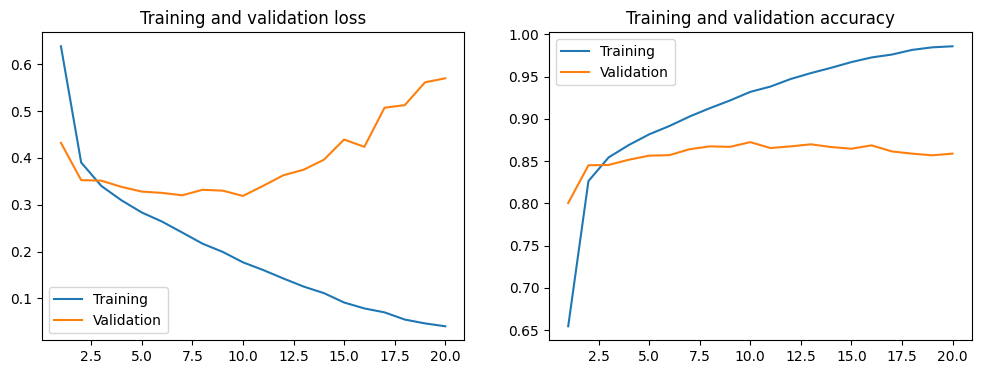

In [12]:
plot_history(history) # a LOT of overfitting

In [13]:
model = tf.keras.models.load_model(
    MODELS_DIR / "transformer_encoder.keras",
    custom_objects={"TransformerEncoder": TransformerEncoder}
)
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.8654 - loss: 0.3325
Test acc: 0.866


#### Implementing positional embedding as a subclassed layer

In [14]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length                   # more params
        self.input_dim = input_dim
        self.output_dim = output_dim

    # new in Keras 3, see: https://keras.io/guides/making_new_layers_and_models_via_subclassing/#best-practice-deferring-weight-creation-until-the-shape-of-the-inputs-is-known
    def build(self, input_shape):
        self.token_embeddings = tf.keras.layers.Embedding(       # token embeddings: semantic information
            input_dim=self.input_dim, output_dim=self.output_dim
        )
        self.position_embeddings = tf.keras.layers.Embedding(    # position embeddings: syntactic/spatial information
            input_dim=self.sequence_length, output_dim=self.output_dim
        )

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        embedded_tokens = self.token_embeddings(inputs)          # 1. create token embeddings
                                                                 # 2. create pos embeddings
        positions = tf.range(start=0, limit=length, delta=1)     #    (as many as our input length, delta: step size)
        embedded_positions = self.position_embeddings(positions)

        return embedded_tokens + embedded_positions              # 3. Both embeddings are simply added together!

    # copied from the source here: https://github.com/keras-team/keras-nlp/blob/4601d88a61a5d3d15279865769af5155804dd785/keras_nlp/src/layers/modeling/token_and_position_embedding.py#L146
    def compute_mask(self, inputs, mask=None):
        return self.token_embeddings.compute_mask(inputs, mask=mask)

    def get_config(self):                                        # retrieve config as a dict
        config = super().get_config()                            # (required for Keras layers)
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

#### Putting it all together: A text-classification Transformer

We go from a **sequence** to a(n abstract) **representation** (= BERT).

<!-- <img style="float:right;height:600px" src="images/transformer/beyer.encoder.png"> -->
<img style="float:right;height:600px"  src="https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/transformer/beyer.encoder.png?raw=true">

<small style="position:absolute;bottom:0;right:0">[Lucas Beyer, "Transformers"](https://docs.google.com/presentation/d/1ZXFIhYczos679r70Yu8vV9uO6B1J0ztzeDxbnBxD1S0/edit#slide=id.g13dd67c5ab8_0_79)</small>

#### Combining the Transformer encoder with positional embedding

In [15]:
vocab_size = 20000
sequence_length = 600
embed_dim = 256
num_heads = 2
dense_dim = 32

inputs = tf.keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'transformer_encoder_1' (of type TransformerEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ positional_embedding      │ (None, None, 256)      │      5,273,600 │ input_layer_3[0][0]    │
│ (PositionalEmbedding)     │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder_1     │ (None, None, 256)      │        543,776 │ positional_embedding[… │
│ (TransformerEncoder)      │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_1    │ (None, 256)            │              0 │ transformer_encoder_1… │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 256)            │              0 │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 1)              │            257 │ dropout_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,817,633 (22.19 MB)

 Trainable params: 5,817,633 (22.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(MODELS_DIR / "full_transformer_encoder.keras"),
        save_best_only=True
    )
]

history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - accuracy: 0.6307 - loss: 0.7581 - val_accuracy: 0.7740 - val_loss: 0.4691
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.8378 - loss: 0.3673 - val_accuracy: 0.8570 - val_loss: 0.3252
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 49ms/step - accuracy: 0.8773 - loss: 0.2904 - val_accuracy: 0.8796 - val_loss: 0.3052
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.9076 - loss: 0.2378 - val_accuracy: 0.8578 - val_loss: 0.4155
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 29s 46ms/step - accuracy: 0.9201 - loss: 0.2017 - val_accuracy: 0.8754 - val_loss: 0.3316
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 48ms/step - accuracy: 0.9395 - loss: 0.1623 - val_accuracy: 0.8696 - val_loss: 0.3478
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9521 - loss: 0.1290 - val_accuracy: 0.8802 - val_loss: 0.3302
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 27s 43ms/step - accuracy: 0.9629 - loss: 0.1024 - val_accurac

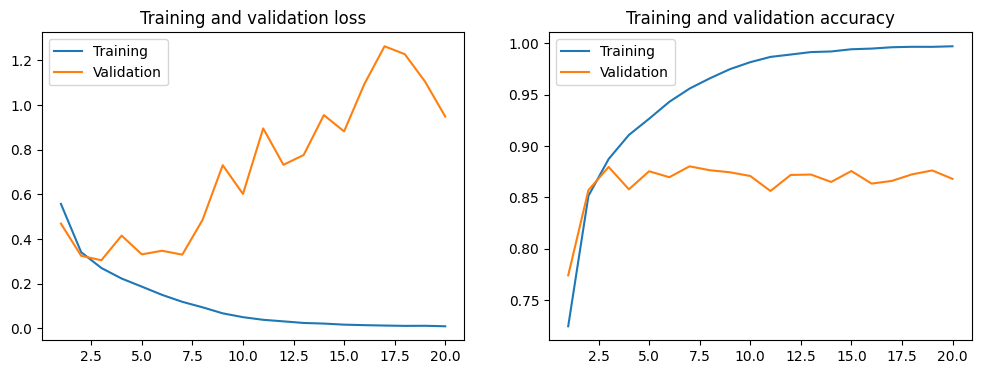

In [17]:
plot_history(history) # overfitting also here

In [18]:
model = tf.keras.models.load_model(
    MODELS_DIR / "full_transformer_encoder.keras",
    custom_objects={                                  # special load syntax as our model uses custom layers!
        "TransformerEncoder": TransformerEncoder,
        "PositionalEmbedding": PositionalEmbedding
    }
)
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'positional_embedding', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8777 - loss: 0.2988
Test acc: 0.878


### Save models to Google Drive


In [22]:
EXPORT=False

if EXPORT:
    # zip models
    !zip aclImdb-transformer.models.zip {MODELS_DIR}/*
    # connect to drive
    from google.colab import drive
    drive.mount('/content/drive')
    # copy zip to drive (adjust folder as needed)
    !cp aclImdb-transformer.models.zip drive/MyDrive/IS53024B-Artificial-Intelligence/models

---

### 11.4.4 When to use sequence models over bag-of-words models?

<!-- ![Chollet When to use sequence models over bag-of-words models](images/chollet.when-to-use-bow.p349.png) -->
![Chollet When to use sequence models over bag-of-words models](https://github.com/jchwenger/AI/blob/main/6-text-and-sequences/images/chollet.when-to-use-bow.p349.png?raw=true)

<small>DLWP, p.349</small>

#### The Transformer applied to translation

The full Transformer (applied to translation) can be found in the notebook [`chapter11_part04_sequence_to_sequence_learning.ipynb`](https://github.com/jchwenger/AI/blob/main/6-additional-material/chapter11_part04_sequence_to_sequence_learning.ipynb).

#### The Transformer applied to vision

[Vision Transformers (ViT) Explained](https://www.pinecone.io/learn/vision-transformers/)

Keras tutorial: [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

## Summary

#### Attention

- **Neural attention** is a way to create context-aware word representations, the basis for the **Transformer**.
  - The operations are $\bbox[5px,border:2px solid red]{“softmax(\mathrm{Queries} \cdot \mathrm{Keys)} \cdot \mathrm{Values}”}$.
  - **Multi-head** attention allows us to split the attention process (similar to different filters in a CNN), looking up different types of information in the input.
  - To enforce causality / prevent lookaheads into the future, we use **masking** to zero out values.
  - Attention **ignores order**: reinject that information with **Position Encoding**.
  

### Transformer  

- The full **Transformer** architecture consists of a TransformerEncoder and a TransformerDecoder, has yielded great results in many fields.  
    - The first half, the **TransformerEncoder**, can also be used for text classification or any sort of single-input NLP task.  
    - The second half, the **TransformerDecoder**, can be used to generate text (like an RNN).  
    - Both were developed together with translation in mind, on the basis of the **sequence to sequence** model.

#### Note

When it comes to text classification, you can use Chollet's ratio to help you determine whether to use a bag-of-words model or a sequence model.